In [2]:
pip install einops


In [1]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize,ToTensor
from torchvision.transforms.functional import to_pil_image

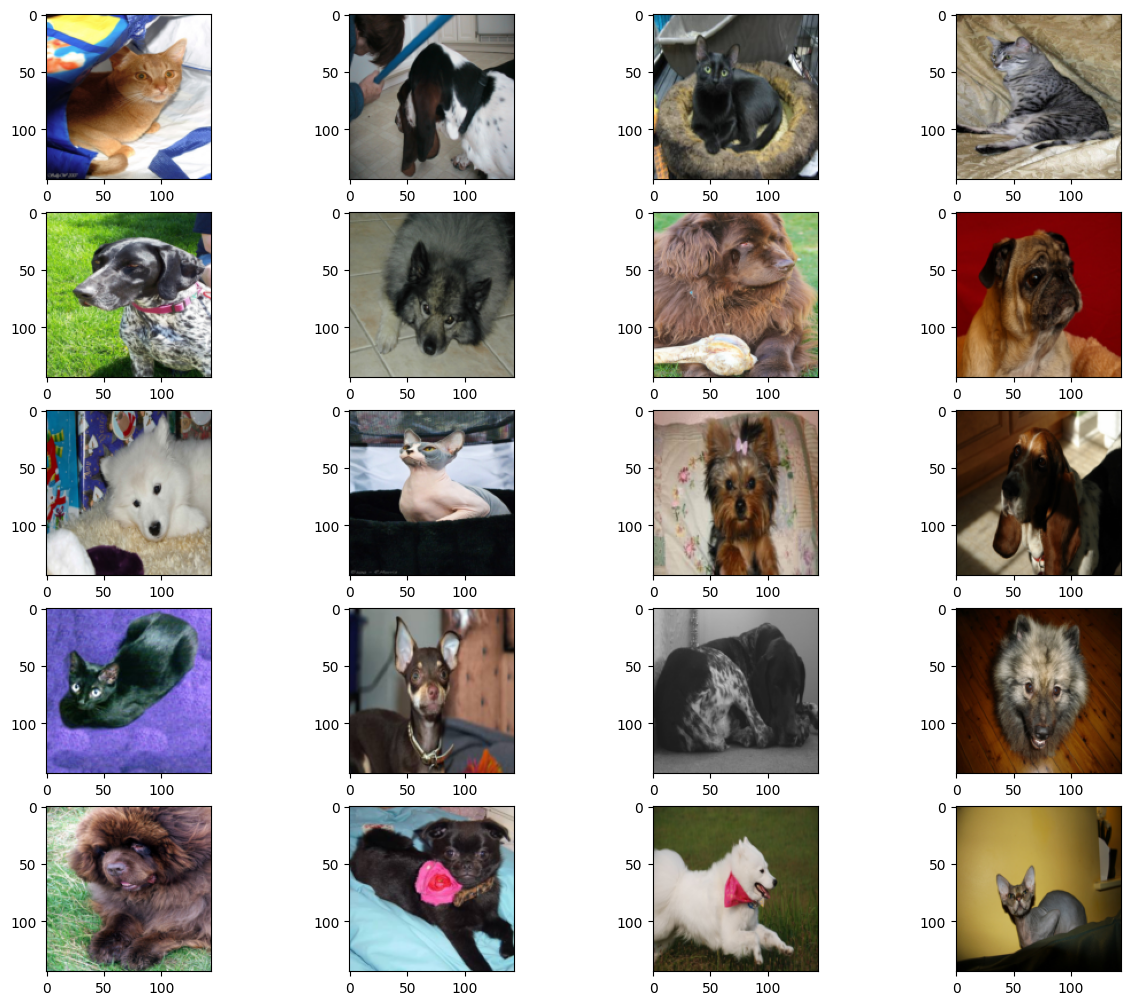

In [10]:
to_tensor=[Resize((144,144)),ToTensor()]

class Compose(object):
    def __init__(self,transforms):
        self.transforms=transforms
    def __call__(self,img,target):
        for t in self.transforms:
            img=t(img)
        return img,target

def show_images(images,num_samples=20,cols=4):
    plt.figure(figsize=(15,15))
    idx=int(len(dataset)/num_samples)
    for i,img in enumerate(images):
        if i%idx==0:
            plt.subplot(int(num_samples/cols)+1,cols,int(i/idx)+1)
            plt.imshow(to_pil_image(img[0]))

dataset=OxfordIIITPet(root='.',download=True,transforms=Compose(to_tensor))
show_images(dataset)

In [16]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor

class PatchEmbedding(nn.Module):
    def __init__(self,in_channels=3,patch_size=8,emb_size=128):
        self.patch_size=patch_size
        super().__init__()
        self.projection=nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)',p1=patch_size,p2=patch_size),
            nn.Linear(patch_size*patch_size*in_channels,emb_size)
        )

    def forward(self,x:Tensor)->Tensor:
        x=self.projection(x)
        return x

sample_datapoint=torch.unsqueeze(dataset[0][0],0)
print("Initial Shape : ",sample_datapoint.shape)

patch_embedding=PatchEmbedding()(sample_datapoint)
print("Final Shape : ",patch_embedding.shape)



Initial Shape :  torch.Size([1, 3, 144, 144])
Final Shape :  torch.Size([1, 324, 128])


In [18]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self,dim,n_heads,dropout):
        super().__init__()
        self.n_heads=n_heads
        self.att=torch.nn.MultiheadAttention(embed_dim=dim,num_heads=n_heads,dropout=dropout)

        self.q=torch.nn.Linear(dim,dim)
        self.k=torch.nn.Linear(dim,dim)
        self.v=torch.nn.Linear(dim,dim)

    def forward(self,x):
        q=self.q(x)
        k=self.k(x)
        v=self.v(x)
        attn_output,attn_output_weights=self.att(q,k,v)
        return attn_output

In [19]:
Attention(dim=128,n_heads=4,dropout=0.)(torch.ones((1,5,128))).shape

torch.Size([1, 5, 128])

In [24]:
class PreNorm(nn.Module):
    def __init__(self,dim,fn):
        super().__init__()
        self.norm=nn.LayerNorm(dim)
        self.fn=fn

    def forward(self,x,**kwargs):
        return self.fn(self.norm(x),**kwargs)

In [25]:
norm=PreNorm(128,Attention(dim=128,n_heads=4,dropout=0.))
norm(torch.ones((1,5,128))).shape

torch.Size([1, 5, 128])

In [27]:
class FeedForward(nn.Sequential):
    def __init__(self,dim,hidden_dim,dropout=0.):
        super().__init__(
            nn.Linear(dim,hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim,dim),
            nn.Dropout(dropout)
        )

ff=FeedForward(dim=128,hidden_dim=256)
ff(torch.ones((1,5,128))).shape

torch.Size([1, 5, 128])

In [28]:
class ResidualAdd(nn.Module):
    def __init__(self,fn):
        super().__init__()
        self.fn=fn

    def forward(self,x,**kwargs):
        res=x
        x=self.fn(x,**kwargs)
        x+=res
        return x


In [29]:
Residual__att=ResidualAdd(Attention(dim=128,n_heads=4,dropout=0.))
Residual__att(torch.ones((1,5,128))).shape

torch.Size([1, 5, 128])

In [30]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))

ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

tensor([[ 0.0523,  0.1533, -0.5381, -0.9227, -0.2259,  0.2682,  0.3311,  1.5345,
          0.4116,  0.4065, -0.5132, -0.1083, -0.4716, -0.8990, -0.7686,  0.3643,
          0.9387,  1.0390,  0.3984,  0.1704,  0.8048,  0.2088, -0.3659, -0.4742,
          0.0915,  0.7754,  0.4435,  0.1428, -0.4123, -0.6582, -0.2692, -0.4350,
          0.0375, -0.4704, -0.6731, -0.3874, -0.0190]],
       grad_fn=<AddmmBackward0>)

In [31]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [32]:
import torch.optim as optim
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1000):
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    if epoch % 5 == 0:
        print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
        epoch_losses = []
        # model.eval()
        for step, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_losses.append(loss.item())
        print(f">>> Epoch {epoch} test loss: ", np.mean(epoch_losses))

cuda
>>> Epoch 0 train loss:  3.6522326288015945
>>> Epoch 0 test loss:  3.6478529909382695
>>> Epoch 5 train loss:  3.62366753557454
>>> Epoch 5 test loss:  3.627541262170543
>>> Epoch 10 train loss:  3.6202734605125757
>>> Epoch 10 test loss:  3.6293798633243726
>>> Epoch 15 train loss:  3.6198023505832837
>>> Epoch 15 test loss:  3.6265500939410664
>>> Epoch 20 train loss:  3.617183778596961
>>> Epoch 20 test loss:  3.628501778063567
>>> Epoch 25 train loss:  3.6169729466023655
>>> Epoch 25 test loss:  3.621108801468559
>>> Epoch 30 train loss:  3.61835204259209
>>> Epoch 30 test loss:  3.625971452049587
>>> Epoch 35 train loss:  3.6158589824386267
>>> Epoch 35 test loss:  3.6266876925592837
>>> Epoch 40 train loss:  3.6149352555689602
>>> Epoch 40 test loss:  3.62434751054515
>>> Epoch 45 train loss:  3.6154121030931887
>>> Epoch 45 test loss:  3.6230041047801143
>>> Epoch 50 train loss:  3.6144639020380764
>>> Epoch 50 test loss:  3.628123252288155
>>> Epoch 55 train loss:  3.6155

KeyboardInterrupt: 